### Importing packages

In [ ]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
#from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta
from scipy.special import boxcox1p
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# mounting the drive to fetch data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/final_df.csv')

In [ ]:
#latest_df = pd.read_excel('/content/drive/MyDrive/cost_discharge_physpec_ippct.xlsx')

In [ ]:
#latest_df.head()

In [ ]:
df.head()

,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_pay_mean,mcare_pay_median,...,ownership_PRIVATE (FOR PROFIT)_mode_y,ownership_PRIVATE (NOT FOR PROFIT)_mode_y,ownership_STATE_mode_y,ownership_TRIBAL_mode_y,urban_rural_URBAN_mode_y,teaching_YES_mode_y,hospital_count,avg_income_2020,population_estimate_2020,Life Expectancy
0,10180,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,8.0,47740.0,173185.0,77.864183
1,10420,2018,Inpatient,breast reconstruction,8.0,19937.08375,16147.330,5692.86,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,11.0,53252.0,701449.0,76.567472
2,10500,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5,0.0,0.0,0.0,1.0,0.0,4.0,45593.0,145206.0,76.615437
3,10540,2018,Inpatient,breast reconstruction,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.5,0.0,0.0,1.0,0.5,2.0,42653.0,131054.0,79.088550
4,10580,2018,Inpatient,breast reconstruction,4.0,14837.26000,10420.675,4474.06,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,17.0,58601.0,878550.0,80.327023


In [ ]:
#df = df.merge(latest_df, left_on = 'group', right_on = 'group')

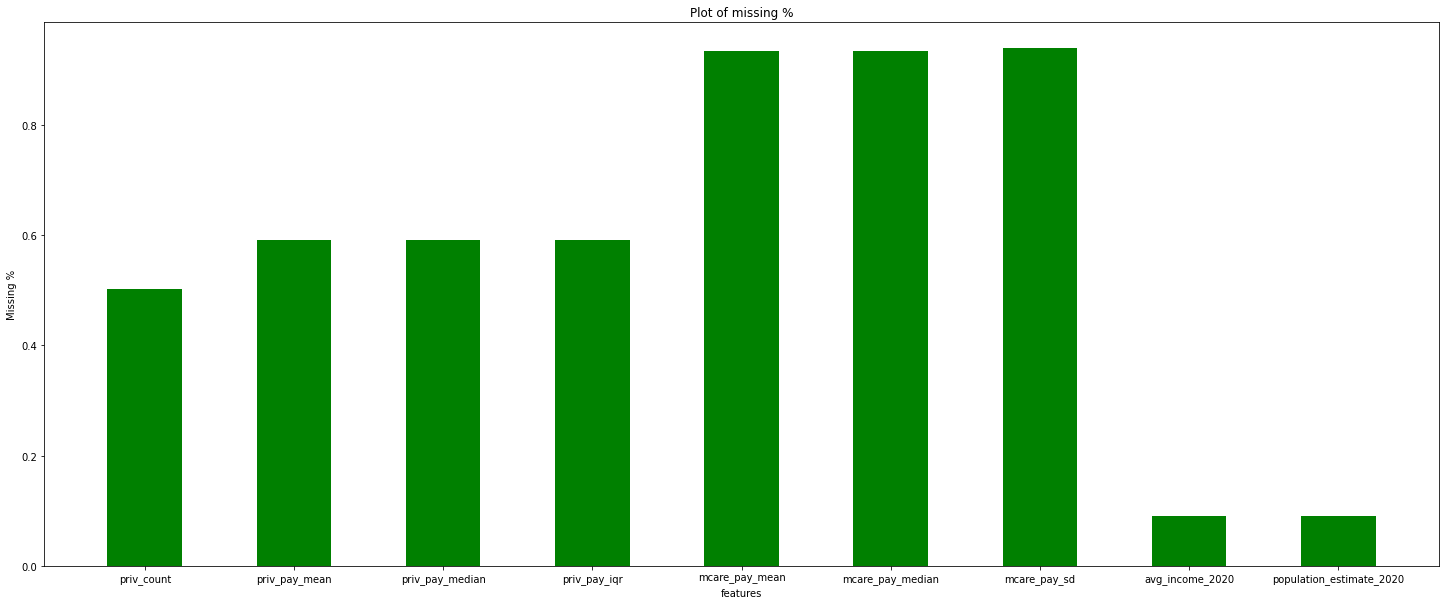

In [ ]:
## finding features with missing values > 2.5%
m = []
idx = []
x = []

for id, i in enumerate(df.columns):
  percent = df[i].isnull().sum()/len(df)
  if percent > 0.025:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [ ]:
for i in df.columns:
  print(i)

msa
year
site
group
priv_count
priv_pay_mean
priv_pay_median
priv_pay_iqr
mcare_pay_mean
mcare_pay_median
mcare_pay_sd
CBSA_NAME
State
FIPS State Code
lon
lat
beds_grp_mean
Covid_payment_mean
beds_grp_greater_500_mean
ownership_FEDERAL_mean
ownership_HOSPITAL DISTRICT OR AUTHORITY_mean
ownership_LOCAL_mean
ownership_OTHER (SPECIFY)_mean
ownership_PHYSICIAN OWNERSHIP_mean
ownership_PRIVATE (FOR PROFIT)_mean
ownership_PRIVATE (NOT FOR PROFIT)_mean
ownership_STATE_mean
ownership_TRIBAL_mean
urban_rural_URBAN_mean
teaching_YES_mean
beds_grp_count
Covid_payment_count
beds_grp_greater_500_count
ownership_FEDERAL_count
ownership_HOSPITAL DISTRICT OR AUTHORITY_count
ownership_LOCAL_count
ownership_OTHER (SPECIFY)_count
ownership_PHYSICIAN OWNERSHIP_count
ownership_PRIVATE (FOR PROFIT)_count
ownership_PRIVATE (NOT FOR PROFIT)_count
ownership_STATE_count
ownership_TRIBAL_count
urban_rural_URBAN_count
teaching_YES_count
beds_grp_exists
Covid_payment_exists
beds_grp_greater_500_exists
ownership_FE

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.express as px

In [ ]:
## function to plot choropleth for different features
def plot_choropleth(df, i):
  state_code = pd.read_csv('/content/drive/MyDrive/us-state-ansi-fips.csv')
  df1 = df.groupby(by = 'FIPS State Code')[i].mean()
  a = state_code.merge(df1.to_frame(), left_on = ' st', right_on= 'FIPS State Code')
  a[' stusps'] = a[' stusps'].apply(lambda x: x.lstrip())

  fig = px.choropleth(a,
                    locations=' stusps',
                    color=i,
                    color_continuous_scale='spectral_r',
                    hover_name='stname',
                    locationmode='USA-states',
                    scope='usa')

  fig.show()

In [ ]:
plot_choropleth(df, 'avg_income_2020')

In [ ]:
plot_choropleth(df, 'Life Expectancy')

In [ ]:
plot_choropleth(df, 'hospital_count')

In [ ]:
df.loc[df.msa == 42540, 'lat'] = 41.408970
df.loc[df.msa == 42540, 'lon'] = -75.662415

In [ ]:
# Adding Lat/Long to into haversine distance

from math import radians, cos, sin, asin, sqrt

def single_pt_haversine(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

df['harvesine_distance'] = [single_pt_haversine(x, y) for x, y in zip(df.lat, df.lon)]
# Geohash.encode(df_valid.iloc[0, list(df_valid.columns).index('lat')], df_valid.iloc[0, list(df_valid.columns).index('lon')])

In [ ]:
df[pd.isna(df['harvesine_distance'])][['msa', 'lat', 'lon', 'CBSA_NAME', 'FIPS State Code']]

,msa,lat,lon,CBSA_NAME,FIPS State Code


In [ ]:
df = df[ (df.priv_pay_mean >0) | (df['priv_pay_mean'].isna())]

In [ ]:
df.site.value_counts()

Outpatient    60982
Inpatient     60972
ASC           10984
Name: site, dtype: int64

In [ ]:
#Since ASC has to be less than outpatient and Inpatient, Assigning  weight 0 to ASC and 1 to other groups.
df['site_weight']  = 1
df.loc[df['site'] == 'ASC', 'site_weight'] = 0
df.site_weight.value_counts()

<ipython-input-21-9a53d6b92b58>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1    121954
0     10984
Name: site_weight, dtype: int64

In [ ]:
#Check for ASC payment > Inpatient payment
df_inpatient = df[ (df['site'] == 'Inpatient') & (~df['priv_pay_mean'].isna())].groupby(['msa','group','year'])['priv_pay_mean'].min().reset_index()
df_inpatient.shape

(19996, 4)

In [ ]:
df_inpatient.columns = ['msa', 'group', 'year', 'min_inpatient_pay']
df_inpatient.head()

,msa,group,year,min_inpatient_pay
0,10180,ankle_fix,2018,50892.66000
1,10180,ant_cerv_fusion,2018,71236.01333
2,10180,ant_cerv_fusion,2019,62690.41000
3,10180,ant_cerv_fusion,2020,78303.19500
4,10180,ant_tls_fusion,2018,35398.22000


In [ ]:
df = pd.merge(df, df_inpatient, on = ['msa', 'group', 'year'], how='left')
df[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC')].shape
## 215 rows have ASC > Inpatient

(215, 107)

In [ ]:
df.loc[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC'), 'priv_pay_mean'] = \
df.loc[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC'), 'min_inpatient_pay']

df[ (~df['priv_pay_mean'].isna()) & (df.priv_pay_mean > df.min_inpatient_pay) & (df.site == 'ASC')].shape

(0, 107)

In [ ]:
df_valid = df[~df['priv_pay_mean'].isna()]
df_valid.shape
## Nearly 60% target is missing

(54183, 107)

In [ ]:
df_valid.group.nunique()
# 3 groups and proccedure types missing. Cannot be predicted.

48

In [ ]:
## fetching procedure level data
df_cluster = pd.read_csv('/content/drive/MyDrive/discharge_physpec_categorised.csv')
df_cluster = df_cluster[~((df_cluster.group == 'lung ablation') & (df_cluster.phy_spec == 'HOSPITALIST\xa0(HOS)'))]
df_cluster = df_cluster[['group', 'pat_cost', 'discharge_to_home_pct', 'phy_spec',
       'IP_pct', 'discharge_category_dbscan', 'discharge_category_kmedoids']]
df_cluster.drop_duplicates(inplace = True)
df_cluster.reset_index(inplace = True, drop = True)
print(df_cluster.shape)
print(df_cluster.group.nunique())

(48, 7)
48


In [ ]:
df_cluster.head()

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,discharge_category_dbscan,discharge_category_kmedoids
0,ankle_fix,16741.5136,0.621714,ORTHOPEDIC SURGERY (ORS),0.542798,0,0
1,ant_cerv_fusion,18848.1697,0.846973,NEUROLOGICAL SURGERY (NS),0.575495,-1,3
2,ant_tls_fusion,49478.1242,0.596666,ORTHOPEDIC SURGERY (ORS),0.983543,0,2
3,bariatric,14585.5550,0.945035,GENERAL SURGERY (GS),0.911311,1,3
4,breast reconstruction,13690.8043,0.929970,PLASTIC SURGERY (PS),0.246127,-1,0


In [ ]:
print(df.shape)
print(df.group.nunique())

(132938, 107)
51


In [ ]:
print(pd.merge(df, df_cluster, on = 'group', how = 'inner').shape)
print(pd.merge(df, df_cluster, on = 'group', how = 'inner')['group'].nunique())

(126834, 113)
48


In [ ]:
df_temp = df_cluster.copy()
df_temp.columns = ['group_procedure', 'pat_cost', 'discharge_to_home_pct', 'phy_spec',
       'IP_pct', 'discharge_category_dbscan', 'discharge_category_kmedoids']

df_temp = df_temp[['group_procedure', 'pat_cost', 'discharge_to_home_pct', 'phy_spec',
       'IP_pct', 'discharge_category_dbscan', 'discharge_category_kmedoids']]

df_temp = df_temp[['group_procedure']]

In [ ]:
df_temp.drop_duplicates(inplace = True)
df_temp.sort_values(by = 'group_procedure', inplace = True)
df_temp.reset_index(inplace = True, drop = True)
df_temp.shape


(48, 1)

In [ ]:
df_temp2 = df.copy()
df_temp2 = df_temp2[['group']]
df_temp2.drop_duplicates(inplace = True)
df_temp2.drop_duplicates(inplace = True)
df_temp2.sort_values(by = 'group', inplace = True)
df_temp2.reset_index(inplace = True, drop = True)
df_temp2.shape

(51, 1)

In [ ]:
print(df.shape)
df = pd.merge(df, df_cluster, on = 'group', how = 'inner')
print(df.shape)

(132938, 107)
(126834, 113)


In [ ]:
df_valid = df[~df['priv_pay_mean'].isna()]
df_valid.shape
## Nearly 60% target is missing

(54123, 113)

In [ ]:
df_valid.group.nunique()
# 3 groups and proccedure types missing. Cannot be predicted.

47

In [ ]:
def get_data_threshold(df, var, thres):
  print('There are {} rows and {} unique groups using {} as theshold'.format( df[df[var] > thres].shape[0], 
                                                                             df[df[var] > thres].group.nunique(), thres ) )

In [ ]:
def get_data_threshold(df, var, thres):
  print('There are {} rows and {} unique groups using {} as theshold'.format( df[df[var] > thres].shape[0], 
                                                                             df[df[var] > thres].group.nunique(), thres ) )

In [ ]:
get_data_threshold(df_valid, 'priv_count', 20)
get_data_threshold(df_valid, 'priv_count', 25)
get_data_threshold(df_valid, 'priv_count', 30)
get_data_threshold(df_valid, 'priv_count', 40)
get_data_threshold(df_valid, 'priv_count', 50)
get_data_threshold(df_valid, 'priv_count', 60)

There are 8087 rows and 41 unique groups using 20 as theshold
There are 6841 rows and 39 unique groups using 25 as theshold
There are 5921 rows and 39 unique groups using 30 as theshold
There are 4680 rows and 38 unique groups using 40 as theshold
There are 3843 rows and 36 unique groups using 50 as theshold
There are 3295 rows and 31 unique groups using 60 as theshold


In [ ]:
copy_df_valid = df_valid.copy()

In [ ]:
#slicing the data
df_valid = df_valid[df['priv_count'] > 30]
df_valid.shape

<ipython-input-42-39709cb9c109>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(5921, 113)

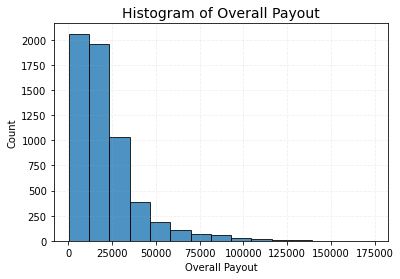

In [ ]:
plt.hist(df_valid.priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

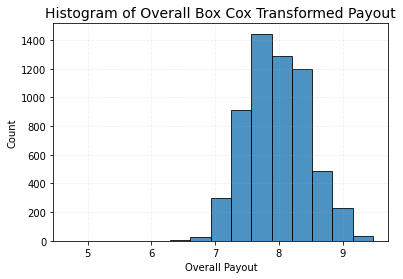

In [ ]:
df_valid['bc_priv_pay_mean'] = stats.boxcox(df_valid['priv_pay_mean'])[0]

plt.hist(df_valid.bc_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Overall Box Cox Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

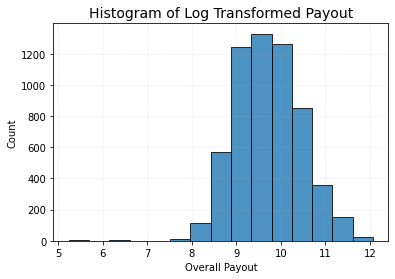

In [ ]:
df_valid['log_priv_pay_mean'] = np.log(df_valid['priv_pay_mean'])

plt.hist(df_valid.log_priv_pay_mean, bins=15, ec="black", alpha=0.8)
plt.xlabel('Overall Payout')
plt.ylabel('Count')
plt.title('Histogram of Log Transformed Payout', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

In [ ]:
## numerical features
num_features = [
'site_weight',
'year',  
'priv_count', 
#'mcare_pay_median',
'ownership_FEDERAL_median','ownership_HOSPITAL DISTRICT OR AUTHORITY_median','ownership_LOCAL_median', 'ownership_OTHER (SPECIFY)_median',
'ownership_PHYSICIAN OWNERSHIP_median', 'ownership_PRIVATE (FOR PROFIT)_median', 'ownership_PRIVATE (NOT FOR PROFIT)_median', 'ownership_STATE_median',
'ownership_TRIBAL_median', 'urban_rural_URBAN_median',
'teaching_YES_median',
'hospital_count', 
'avg_income_2020',
'population_estimate_2020', 
'Life Expectancy', 
'harvesine_distance',
'Covid_payment_median', 
'beds_grp_median','beds_grp_greater_500_median',
'pat_cost', 
'discharge_to_home_pct',
'IP_pct'
]
len(num_features)

25

In [ ]:
## one hot encoded feature
ohe_features = ['site', ]
## features for which we have applied target encoding
tar_enc_features = ['group', 'msa', 'phy_spec']

In [ ]:
## final features which are 29 in count
all_features = num_features + ohe_features + tar_enc_features
len(all_features)

29

In [ ]:
df.shape

(126834, 113)

### Data Visualization

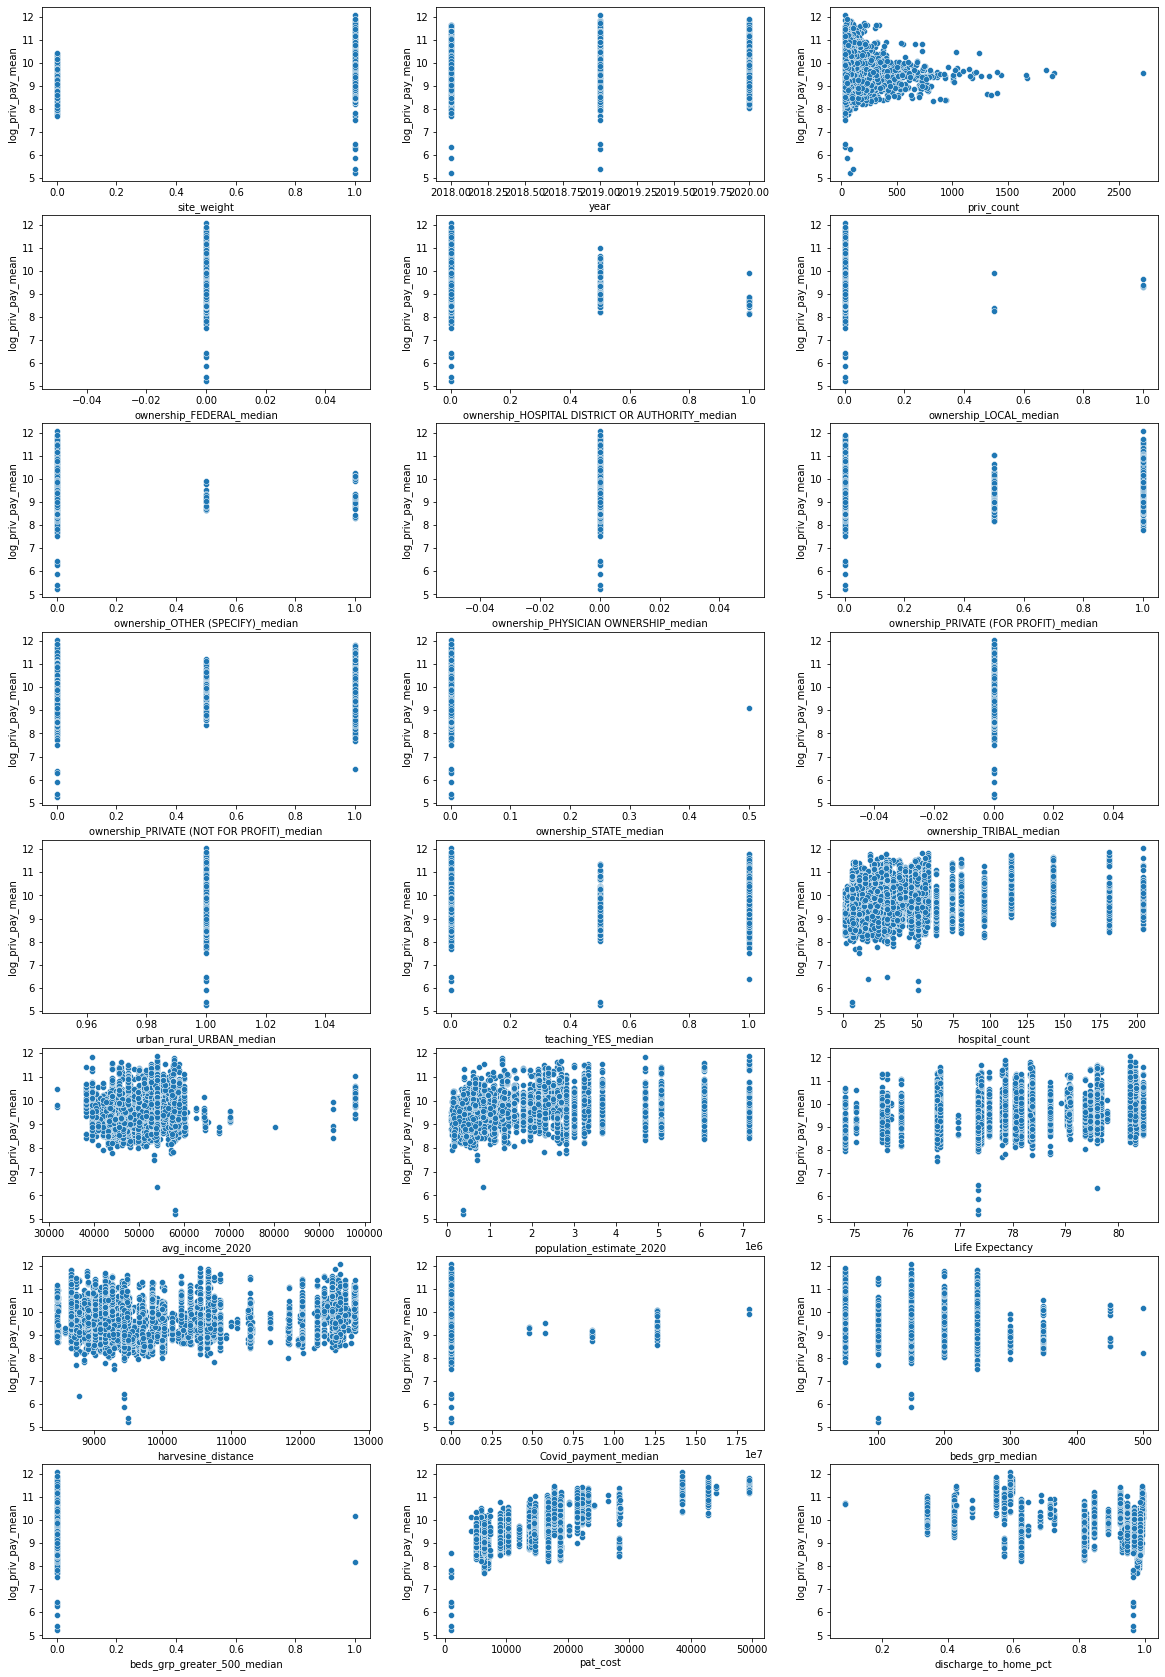

In [ ]:
### Plotting all the numerical features 
fig, ax = plt.subplots(8, 3, figsize = (20,30))

for col, subplot in zip(num_features, ax.flatten()):
    sns.scatterplot(x=col, y=df_valid['log_priv_pay_mean'], data = df_valid[num_features] , ax= subplot)
plt.show(fig)

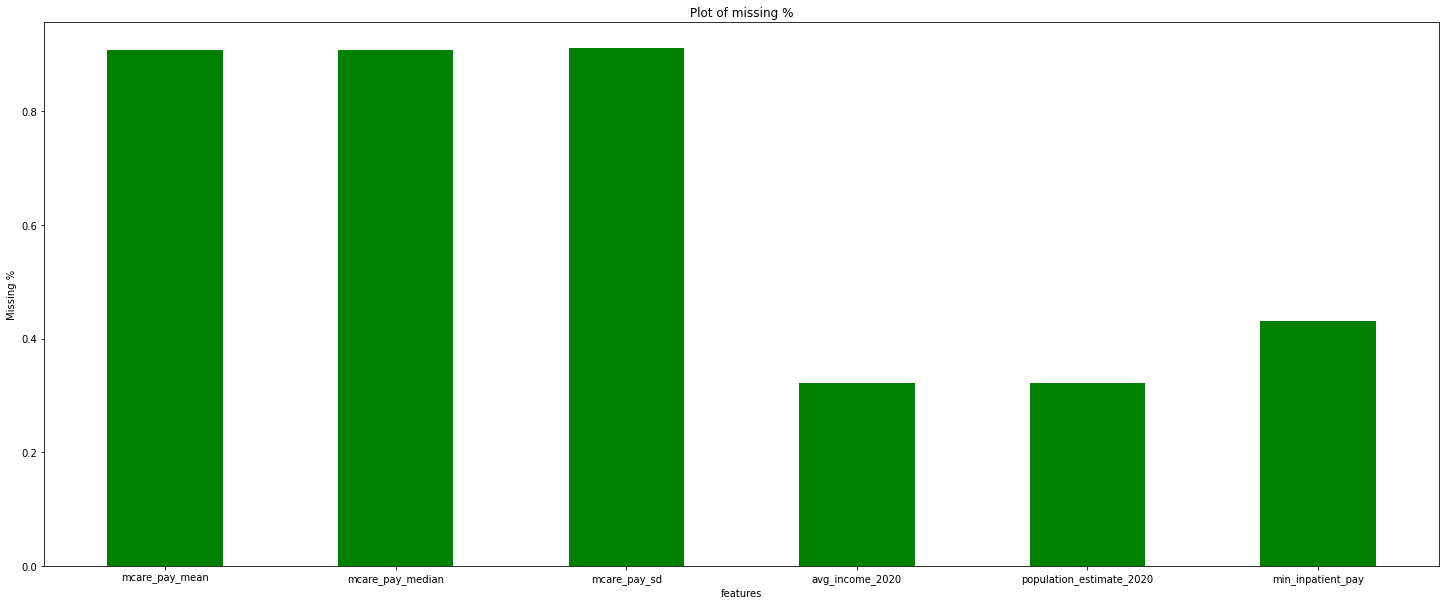

In [ ]:
## plotting missing values for final dataset i.e df_valid
m = []
idx = []
x = []

for id, i in enumerate(df_valid.columns):
  percent = df_valid[i].isnull().sum()/len(df_valid)
  if percent > 0.01:
    idx.append(id)
    m.append(percent)

for i in idx:
  x.append(list(df_valid.columns)[i])

plt.figure(figsize=(25,10))
plt.bar(x, m, color ='green', width = 0.5)
plt.xlabel("features")
plt.ylabel("Missing %")
plt.title("Plot of missing %")
plt.show()

In [ ]:
df_valid[df_valid['population_estimate_2020'].isnull()][['msa', 'population_estimate_2020', 'FIPS State Code']]

,msa,population_estimate_2020,FIPS State Code
89,19124,NaN,48
261,35614,NaN,34
496,19124,NaN,48
667,35614,NaN,34
902,19124,NaN,48
...,...,...,...
126154,23104,NaN,48
126402,47664,NaN,26
126516,19124,NaN,48
126688,35614,NaN,34


In [ ]:
df_valid.isnull().sum()

msa                            0
year                           0
site                           0
group                          0
priv_count                     0
                              ..
IP_pct                         0
discharge_category_dbscan      0
discharge_category_kmedoids    0
bc_priv_pay_mean               0
log_priv_pay_mean              0
Length: 115, dtype: int64

In [ ]:
df_valid = df_valid[~df_valid['teaching_YES_mode_y'].isnull()]

In [ ]:
## imputing missing values
df_valid['population_estimate_2020'] = df_valid['population_estimate_2020'].fillna(df_valid['population_estimate_2020'].mean())
df_valid['avg_income_2020'] = df_valid['avg_income_2020'].fillna(df_valid['avg_income_2020'].mean())

<ipython-input-55-ccbdaeb93043>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-55-ccbdaeb93043>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
## checking if any column has missing value
df_valid.isnull().sum()

msa                            0
year                           0
site                           0
group                          0
priv_count                     0
                              ..
IP_pct                         0
discharge_category_dbscan      0
discharge_category_kmedoids    0
bc_priv_pay_mean               0
log_priv_pay_mean              0
Length: 115, dtype: int64

In [ ]:
df_valid.shape

(5885, 115)

### Data Split

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
!pip install category_encoders
from category_encoders import TargetEncoder
import time
from datetime import timedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.2 MB/s 


In [ ]:
df_valid_X = df_valid[all_features] ## all the features
df_valid_y = df_valid['log_priv_pay_mean'] ## target variable

### Model Building

In [ ]:
##creating pipeline
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), tar_enc_features),
                                      remainder = 'passthrough'
                                     )

In [ ]:
## defining mape function
def mape(pred, actual):
  mape = 0
  for (p, a) in zip(pred, actual):
     mape += abs(p-a)/a
  return mape/(1+len(pred)) 

In [ ]:
## creating 80/20 split
df_valid_X_dev, df_valid_X_test, df_valid_y_dev, df_valid_y_test = train_test_split(df_valid_X, df_valid_y, test_size=0.20, random_state=0)

#### XGBoost + Bayesian Optimization

In [ ]:
from xgboost import XGBRegressor

In [ ]:
x = tuple([1] + [0]*28) ## array with all 0s except first element that is 1 for monotonicity constraint for site_weight

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## defining search space
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 0, 5),
        'reg_alpha' : hp.quniform('reg_alpha', 0, 20,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.9, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 400, 1000, 50),
        'seed': 0
    }

In [ ]:
X_train, y_train = df_valid_X_dev, df_valid_y_dev
X_test, y_test = df_valid_X_test, df_valid_y_test
train_mape = []
test_mape = []
def objective(space):

  pipe_xgb = make_pipeline(preprocess, XGBRegressor (n_estimators = int(space['n_estimators']), 
                                                     max_depth = int(space['max_depth']), 
                                                     gamma = space['gamma'],
                                                     reg_alpha = int(space['reg_alpha']),
                                                     objective ='reg:squarederror',
                                                     monotone = x))
  
  evaluation = [( X_train, y_train), ( X_test, y_test)]
    
  pipe_xgb.fit(X_train, y_train)
  pred = pipe_xgb.predict(X_test)
  m = mape(np.exp(pipe_xgb.predict(df_valid_X_test)), np.exp(df_valid_y_test))
  m1 = mape(np.exp(pipe_xgb.predict(df_valid_X_dev)), np.exp(df_valid_y_dev))

  m1 = "{:.3f}".format(m1)
  m = "{:.3f}".format(m)
  train_mape.append(m1)
  test_mape.append(m)

  print ("Train MAPE", m1, 
         "Test MAPE", m)
  return {'loss': m, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

Train MAPE
0.225
Test MAPE
0.223
Train MAPE
0.219
Test MAPE
0.220
Train MAPE
0.233
Test MAPE
0.229
Train MAPE
0.203
Test MAPE
0.208
Train MAPE
0.191
Test MAPE
0.196
Train MAPE
0.214
Test MAPE
0.217
Train MAPE
0.188
Test MAPE
0.194
Train MAPE
0.243
Test MAPE
0.241
Train MAPE
0.200
Test MAPE
0.202
Train MAPE
0.248
Test MAPE
0.244
Train MAPE
0.242
Test MAPE
0.239
Train MAPE
0.247
Test MAPE
0.243
Train MAPE
0.238
Test MAPE
0.236
Train MAPE
0.227
Test MAPE
0.226
Train MAPE
0.224
Test MAPE
0.226
Train MAPE
0.237
Test MAPE
0.236
Train MAPE
0.251
Test MAPE
0.247
Train MAPE
0.216
Test MAPE
0.216
Train MAPE
0.229
Test MAPE
0.227
Train MAPE
0.244
Test MAPE
0.238
Train MAPE
0.156
Test MAPE
0.171
Train MAPE
0.164
Test MAPE
0.178
Train MAPE
0.144
Test MAPE
0.166
Train MAPE
0.149
Test MAPE
0.167
Train MAPE
0.182
Test MAPE
0.187
Train MAPE
0.168
Test MAPE
0.179
Train MAPE
0.193
Test MAPE
0.199
Train MAPE
0.168
Test MAPE
0.180
Train MAPE
0.243
Test MAPE
0.239
Train MAPE
0.214
Test MAPE
0.215
Train MAPE

## Evaluation on best parameters:

In [ ]:
start_time_xgb = time.monotonic()
pipe_xgb = make_pipeline(preprocess, XGBRegressor (n_estimators = int(900.0), 
                                                     max_depth = int(10.0), 
                                                     gamma = 0.014825550580583137,
                                                     reg_alpha = int(2.0),
                                                     objective ='reg:squarederror',
                                                     monotone = x, ## this helps to implement the monotonicity constraint
                                                     tree_method = 'exact'))

pipe_fit_xgb = pipe_xgb.fit(df_valid_X_dev, df_valid_y_dev)

In [ ]:
print(f"Performance on Test Dataset is: {pipe_xgb.score(df_valid_X_test, df_valid_y_test) :3f}")
mape(np.exp(pipe_xgb.predict(df_valid_X_test)), np.exp(df_valid_y_test))

Performance on Test Dataset is: 0.934659


0.14026890022967267

In [ ]:
#check_df = pd.concat([copy_df_valid.reset_index(drop = True), pd.DataFrame(np.exp(pipe_xgb.predict(copy_df_valid)), columns = ['predictions'])], axis = 1)
check_df = pd.concat([df_valid_X_test.reset_index(drop = True), 
                      pd.DataFrame(np.exp(pipe_xgb.predict(df_valid_X_test)), columns = ['predictions']),
                      pd.DataFrame(df_valid_y_test.reset_index(drop = True))], axis = 1)
check_df.head()

,site_weight,year,priv_count,ownership_FEDERAL_median,ownership_HOSPITAL DISTRICT OR AUTHORITY_median,ownership_LOCAL_median,ownership_OTHER (SPECIFY)_median,ownership_PHYSICIAN OWNERSHIP_median,ownership_PRIVATE (FOR PROFIT)_median,ownership_PRIVATE (NOT FOR PROFIT)_median,...,beds_grp_greater_500_median,pat_cost,discharge_to_home_pct,IP_pct,site,group,msa,phy_spec,predictions,log_priv_pay_mean
0,1,2020,31.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,8922.4310,0.984233,0.000000,Outpatient,robotic_assisted_surgery,22744,GENERAL SURGERY (GS),11687.338867,9.824409
1,1,2018,1007.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,9390.2633,0.930895,0.131144,Outpatient,mastectomy,35614,GENERAL SURGERY (GS),13665.017578,9.433972
2,0,2019,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16741.5136,0.621714,0.542798,ASC,ankle_fix,12060,ORTHOPEDIC SURGERY (ORS),7500.948730,8.697315
3,1,2019,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16741.5136,0.621714,0.542798,Outpatient,ankle_fix,18140,ORTHOPEDIC SURGERY (ORS),18933.789062,9.846485
4,1,2018,41.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,6433.5226,0.988582,0.000000,Outpatient,lap appendectomy,39340,GENERAL SURGERY (GS),8187.880371,8.784543


In [ ]:
from pandas.core.window.common import defaultdict
dict1 = defaultdict(float)
dict2 = defaultdict(float) 
i = 0
for k, v in check_df[check_df.site == 'ASC'].groupby(['msa', 'group', 'year']):
  dict1[k] = v['predictions'].values[0]

for k, v in check_df[check_df.site == 'Inpatient'].groupby(['msa', 'group', 'year']):
  dict2[k] = v['predictions'].values[0]

In [ ]:
## checking for all (msa, year and group) key to find ASC < Inpatient
i = 0
j = 0
for k in dict2:
  if k in dict1:
    #print(k)
    j+=1
    if dict1[k] >= dict2[k]:
      i+=1
print(i, j)

0 4


In [ ]:
end_time_xgb = time.monotonic()
print(end_time_xgb - start_time_xgb)

21.432462115000135


In [ ]:
train_mape = [float(i) for i in train_mape]
test_mape = [float(i) for i in test_mape]
train_mape

[0.225,
 0.219,
 0.233,
 0.203,
 0.191,
 0.214,
 0.188,
 0.243,
 0.2,
 0.248,
 0.242,
 0.247,
 0.238,
 0.227,
 0.224,
 0.237,
 0.251,
 0.216,
 0.229,
 0.244,
 0.156,
 0.164,
 0.144,
 0.149,
 0.182,
 0.168,
 0.193,
 0.168,
 0.243,
 0.214,
 0.172,
 0.213,
 0.204,
 0.226,
 0.24,
 0.205,
 0.234,
 0.171,
 0.187,
 0.212,
 0.177,
 0.202,
 0.163,
 0.194,
 0.236,
 0.238,
 0.212,
 0.231,
 0.229,
 0.234,
 0.201,
 0.235,
 0.191,
 0.197,
 0.239,
 0.225,
 0.217,
 0.14,
 0.178,
 0.176,
 0.232,
 0.193,
 0.251,
 0.193,
 0.223,
 0.135,
 0.13,
 0.183,
 0.172,
 0.171,
 0.182,
 0.173,
 0.139,
 0.173,
 0.153,
 0.198,
 0.155,
 0.182,
 0.202,
 0.116,
 0.19,
 0.184,
 0.192,
 0.107,
 0.186,
 0.208,
 0.139,
 0.132,
 0.189,
 0.226,
 0.224,
 0.175,
 0.136,
 0.172,
 0.213,
 0.229,
 0.201,
 0.109,
 0.196,
 0.129]

Text(0.5, 1.0, 'Test MAPE vs Trials for 100 trials of Bayesian Optimization')

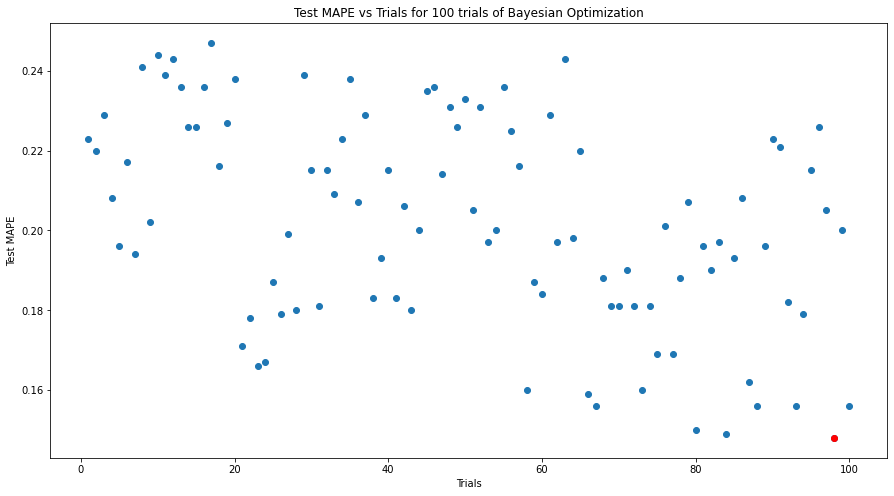

In [ ]:
y = [i for i in range(1, 101)]
plt.figure(figsize=(15,8))
plt.scatter(y, test_mape)
ind = test_mape.index(min(test_mape)) 
plt.plot(y[ind],test_mape[ind],"ro")
plt.xlabel("Trials")
plt.ylabel("Test MAPE")
plt.title("Test MAPE vs Trials for 100 trials of Bayesian Optimization")

In [ ]:
out = {}
count = 0
from sklearn.metrics import mean_absolute_percentage_error as MAPE
for grp in check_df['group'].unique():
    temp = check_df[check_df['group'] == grp]
    out[grp] = (MAPE(temp['predictions'], np.exp(temp['log_priv_pay_mean'])))
sorted(out.items(), key = lambda x: x) 

[('ankle_fix', 0.18135705104839211),
 ('ant_cerv_fusion', 0.18333615949925108),
 ('ant_tls_fusion', 0.12260389208946743),
 ('bariatric', 0.11905967808873935),
 ('breast reconstruction', 0.16582336649025273),
 ('bsp', 0.2078118881344618),
 ('bunionectomy', 0.1816512854501887),
 ('cardiac ablation', 0.09925970802188043),
 ('cardiac ablation_additional_discrete', 0.19562691654210002),
 ('cardiac ablation_linear_focal', 0.26758951043524415),
 ('cardiac_ablaton_anesthesia', 0.13668873973548087),
 ('cardiac_ablaton_ice', 0.13396206317585027),
 ('clavicle fixation', 0.08702848301133023),
 ('colorect', 0.1408614513969996),
 ('fess', 0.148015821392498),
 ('hepat', 0.3358524224491219),
 ('hernia', 0.14110462669486057),
 ('hysterect', 0.13815847844265386),
 ('lap appendectomy', 0.0863646425758582),
 ('mastectomy', 0.14927672425189084),
 ('navigation', 0.14562189498914702),
 ('orthovisc_monovisc', 0.480692142926932),
 ('pka', 0.17852521888934203),
 ('post_tls_fusion', 0.12123655829597861),
 ('pros

In [ ]:
pipe_xgb.named_steps['xgbregressor'].feature_importances_

array([0.03615991, 0.01107214, 0.00219886, 0.        , 0.00241819,
       0.00338302, 0.00557351, 0.        , 0.00423027, 0.00409384,
       0.00203991, 0.        , 0.        , 0.00500012, 0.00716122,
       0.00457213, 0.0087842 , 0.01360814, 0.01094294, 0.00633486,
       0.00625033, 0.        , 0.01391438, 0.00350026, 0.00644136,
       0.        , 0.24440703, 0.00383442, 0.58086246, 0.00700809,
       0.0062084 ], dtype=float32)

### Top 8 final features in the XGBoost model after monotonicity constraint on site_weight

Text(0, 0.5, 'Feature Importance')

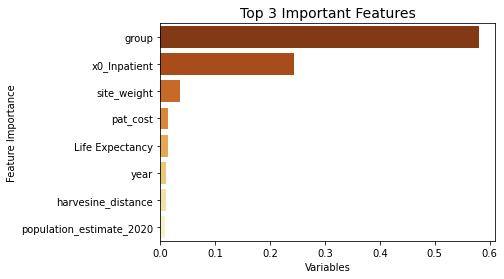

In [ ]:
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
te_feature_names = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = num_features + ohe_feature_names+te_feature_names  

feat_imps = zip(feature_names, pipe_xgb.named_steps['xgbregressor'].feature_importances_)

feats, imps = zip(*(sorted(list(filter( lambda x : x[1]!=0 , feat_imps)), key = lambda x : x[1] , reverse=True)))

ax = sns.barplot(list(imps)[:8], list(feats)[:8], palette=("YlOrBr_r"))
ax.tick_params(axis='x', rotation = 0)
plt.title("Top 3 Important Features", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Feature Importance")

In [ ]:
list(imps)[:8], list(feats)[:8]

([0.58086246,
  0.24440703,
  0.036159907,
  0.013914383,
  0.013608142,
  0.011072136,
  0.010942939,
  0.0087842],
 ['group',
  'x0_Inpatient',
  'site_weight',
  'pat_cost',
  'Life Expectancy',
  'year',
  'harvesine_distance',
  'population_estimate_2020'])